In [1]:
import tensorflow as tf

from os import listdir
import os

from utils import configure_gpu_options
from contrPredCod_model import CPC
from training import train_step
from preprocess_data import get_cpc_gen, get_ae_gen

## ToDo:
1. check for broken/corrupted audio files (1. load file, 2. decode, 3. check length)
2. make nice thingy to listen to some tracks
3. make Autoencoder training (model, generator, training loop)

# Small functions

In [2]:
# Loss function
class InfoNCE (tf.keras.losses.Loss):
    '''
    Compute loss given batch times f matrices with dim (K x N)
    '''

    def __call__(self, f):
        # input dim: [batch, K, N]
        denominator = tf.reduce_sum(f, axis=2)  # [batch, K]
        losses = - tf.math.log(f[:,:,0] / denominator)  # first column is positive
        return tf.reduce_mean(tf.reduce_mean(losses, axis=1),axis=-1)  # [batch]. Take a mean over k timesteps

# 1. Training of the Autoencoder

## Data pipeline

In [26]:
rel_folder = "data/gtzan/no_genres/"
file_names = listdir(rel_folder)
file_paths = [os.path.join(rel_folder, fn) for fn in file_names]

data_generator_ae_arguments = {
    "full_duration" : 30,
    "original_sr" : 22050,
    "desired_sr" : 22050,
    "filepaths" : file_paths,
    "batch_size" : 64
}
       
ae_gen = get_ae_gen(data_generator_ae_arguments)()
print(next(ae_gen))

tf.Tensor(
[[ 0.03918457]
 [ 0.02008057]
 [-0.03701782]
 ...
 [-0.17193604]
 [-0.19311523]
 [-0.20928955]], shape=(22050, 1), dtype=float32)


In [4]:
ae_output_shape = tf.TensorSpec([data_generator_ae_arguments['desired_sr'], 1], dtype=tf.dtypes.float32, name=None)
ae_train_ds = tf.data.Dataset.from_generator(generator=get_ae_gen(data_generator_ae_arguments),
                                          output_signature=ae_output_shape).batch(data_generator_ae_arguments['batch_size'])

for inp in ae_train_ds.take(1):
    print(inp.shape)

(64, 22050, 1)


## Model initialization

In [143]:
class CNN_Encoder(tf.keras.layers.Layer):
    def __init__(self, z_dim):
        super(CNN_Encoder, self).__init__()

        s = [8, 6, 3, 2, 2]  # stride sizes
        k = [10, 8, 6, 4, 4]  # kernel sizes
        f = [64, 128, 256, 256, 512]  # num filters

        # input dim: [batch, T+K*N, d, 1]
        self.enc_layers = []
        for l in range(5):
            self.enc_layers.append(tf.keras.layers.Conv1D(f[l],k[l],s[l], padding='same'))
            self.enc_layers.append(tf.keras.layers.BatchNormalization())
            self.enc_layers.append(tf.keras.layers.Activation('relu'))
        self.enc_layers.append(tf.keras.layers.GlobalAveragePooling1D())
        self.enc_layers.append(tf.keras.layers.Dense(z_dim, activation='tanh'))

    def call(self, x, training=False):
        for layer in self.enc_layers:
            try:  # training argument only for BN layer
                print(x.shape)
                x = layer(x, training)
            except:
                x = layer(x)
        return tf.expand_dims(x, axis=-1)


class CNN_Decoder(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(CNN_Decoder, self).__init__()
        self.layers = []
        
        f = [512, 265, 128]#, 64]
        s = [2, 3, 4]#, 7]
        k = [4, 6, 8]#, 10]
        
        self.layers.append(tf.keras.layers.Dense(f[0]))
        self.layers.append(tf.keras.layers.BatchNormalization())
        self.layers.append(tf.keras.layers.Activation('relu'))
        
        for l in range(len(f)):
            self.layers.append(tf.keras.layers.Conv1DTranspose(filters=f[l], kernel_size=k[l], strides=s[l], padding='same'))
            self.layers.append(tf.keras.layers.BatchNormalization())
            self.layers.append(tf.keras.layers.Activation('relu'))
            
        self.layers.append(tf.keras.layers.Conv1D(1, 1, 1))
        self.layers.append(tf.keras.layers.Dense(output_dim, activation='tanh'))
        

    def call(self, x, training=False):
        for layer in self.layers:
            print(x.shape)
            try:  # training argument only for BN layer
                x = layer(x, training)
            except:
                x = layer(x)
        return x

class CNN_Autoencoder(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(CNN_Autoencoder, self).__init__()
        # encoder and decoder are symmetric
        self.encoder = CNN_Encoder(128)
        self.decoder = CNN_Decoder(restore_shape=restore_shape)

    def call(self, x, training=False):
        x = self.encoder(x, training)
        self.latent_repr = x  # keep latent_repr as property in case it should be analyzed
        x = self.decoder(x, training)
        return x

In [141]:
enc = CNN_Encoder(128)
dec = CNN_Decoder(22050)

In [142]:
for inp in ae_train_ds.take(1):
    latent = enc(inp)
    print('latent dim', latent.shape)
    out = dec(latent)
    print(out.shape)

(64, 22050, 1)
(64, 2757, 64)
(64, 2757, 64)
(64, 2757, 64)
(64, 460, 128)
(64, 460, 128)
(64, 460, 128)
(64, 154, 256)
(64, 154, 256)
(64, 154, 256)
(64, 77, 256)
(64, 77, 256)
(64, 77, 256)
(64, 39, 512)
(64, 39, 512)
(64, 39, 512)
(64, 512)
latent dim (64, 128, 1)
(64, 128, 1)
(64, 128, 512)
(64, 128, 512)
(64, 128, 512)
(64, 256, 512)
(64, 256, 512)
(64, 256, 512)
(64, 768, 265)
(64, 768, 265)
(64, 768, 265)
(64, 3072, 128)
(64, 3072, 128)
(64, 3072, 128)
(64, 3072, 1)


ResourceExhaustedError: OOM when allocating tensor with shape[196608,22050] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:MatMul]

## Training

# 2. Training of the CPC model

## Data pipeline

In [5]:
rel_folder = "data/gtzan/no_genres/"

file_names = listdir(rel_folder)
file_paths = [os.path.join(rel_folder, fn) for fn in file_names]

data_generator_cpc_arguments = {
    "T" : 20,
    "k" : 10,
    "N" : 8,
    "window_duration" : 1,
    "full_duration" : 30,
    "original_sr" : 22050,
    "desired_sr" : 8000,
    "filepaths" : file_paths,
    "batch_size" : 8
    }

# Check if DataGen output is correct
cpc_gen = get_cpc_gen(data_generator_cpc_arguments)()
print(next(cpc_gen).shape)

(100, 8000, 1)


In [7]:
T = data_generator_cpc_arguments["T"]
k = data_generator_cpc_arguments["k"]
N = data_generator_cpc_arguments["N"]
sampling_rate = data_generator_cpc_arguments["desired_sr"]
window_duration = data_generator_cpc_arguments["window_duration"]
batch_size = data_generator_cpc_arguments["batch_size"]

cpc_data_shape = (T+k*N, sampling_rate * window_duration, 1)
cpc_output_shape = tf.TensorSpec(cpc_data_shape, dtype=tf.dtypes.float32, name=None)

cpc_train_ds = tf.data.Dataset.from_generator(generator=get_cpc_gen(data_generator_cpc_arguments),
                                          output_signature=cpc_output_shape).batch(batch_size)

# check if batch_dim is added
for inp in cpc_train_ds.take(1):
    print(inp.shape)

(8, 100, 8000, 1)


## Model initialization

In [8]:
tf.keras.backend.clear_session()
configure_gpu_options()

z_dim = 256  # latent dim z_t
c_dim = 512  # dim of g_ar output c_t

cpc = CPC(T, k, N, z_dim, c_dim)
loss = InfoNCE()

In [9]:
for i in cpc_train_ds.take(1):
    nce_loss = loss(cpc(i))
    
tf.print(nce_loss)

2.07944298


## Training

In [10]:
epochs = 3000
train_loss_metric = tf.keras.metrics.Mean('train_loss')
optimizer = tf.keras.optimizers.Adam(1e-3)

for e in range(epochs):
    train_step(cpc, cpc_train_ds, loss, optimizer, 1, train_loss_metric)

    if e%1 == 0:
        print(train_loss_metric.result().numpy())
        train_loss_metric.reset_states()

2.079444


KeyboardInterrupt: 

In [16]:
cpc.variables[0].shape

TensorShape([20, 1, 128])

# The Model explained

In [ ]:
# Model (output of call function is the InfoNCE loss)

class CPC(tf.keras.Model):
    def __init__(self, k_steps):
        super(CPC,self).__init__()

        # number of timesteps to predict
        self.k_steps = k_steps

        # encoder: transforms windows of the audio into embeddings up to z_t
        self.g_enc = Encoder()

        # autoregressive model: predicts c_t based on z_t of the past k-steps into the future
        self.g_ar = AutoRegressive()

        # k times W for each z_t prediction
        self.linear_projections = [tf.keras.layers.Dense(output_size) for i in tf.range(k_steps)]

    def call(self, X):

        # process every window in X to get an embedding c_t (for positive and for negative samples)
        pass

        # process every embedding c_t with g_ar to calculate all z_t+k


### f score calculation
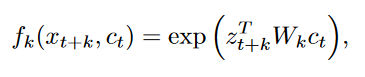


### f score meaning

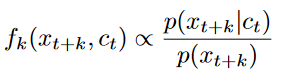



### maximizing correct f score vs incorrect f scores means maximizing mutual information between z_tk and c_t

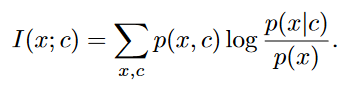


### InfoNCE loss: maximize mutual information between correct future timestep encoding and past context and minimize mutual information between false future timestep encoding and past context

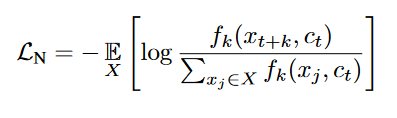